In [1]:
import os.path
import tensorflow as tf
import numpy as np
from utils import label_map_util
from utils import visualization_utils as vis_util

In [2]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'models/frozen_inference_graph_sim.pb'
path_to_labels = 'models/label_map.pbtxt'
num_classes = 4

label_map = label_map_util.load_labelmap(path_to_labels)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes, use_display_name=True)

category_index = label_map_util.create_category_index(categories)

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [4]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores',
                        'detection_classes']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            
    return output_dict

In [5]:
from PIL import Image
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'img_00000{}.png'.format(i)) for i in range(1, 2)]

In [6]:
TEST_IMAGE_PATHS

['test_images/img_000001.png']

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

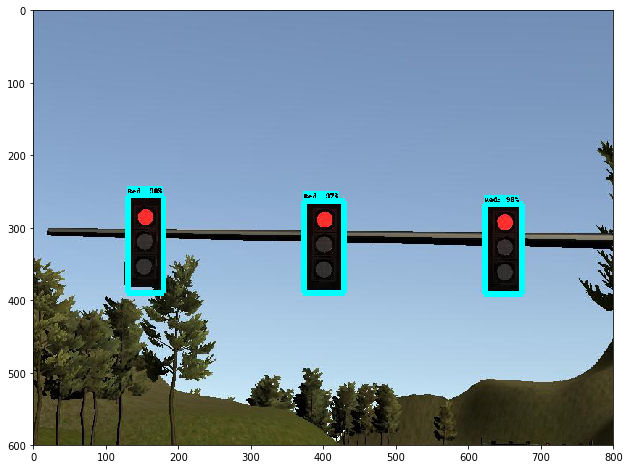

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline  

IMAGE_SIZE = (12, 8)

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),use_normalized_coordinates=True,line_thickness=8)
    
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [9]:
output_dict

{'detection_boxes': array([[0.4281907 , 0.1630451 , 0.64989436, 0.22551386],
        [0.44757217, 0.7786745 , 0.6524485 , 0.8442712 ],
        [0.43993172, 0.46730623, 0.6497938 , 0.5373722 ],
        [0.43993172, 0.46730623, 0.6497938 , 0.5373722 ],
        [0.4281907 , 0.1630451 , 0.64989436, 0.22551386],
        [0.44757217, 0.7786745 , 0.6524485 , 0.8442712 ],
        [0.4281907 , 0.1630451 , 0.64989436, 0.22551386],
        [0.        , 0.        , 0.94855124, 0.9661366 ],
        [0.        , 0.24784717, 1.        , 0.7828717 ],
        [0.        , 0.24784717, 1.        , 0.7828717 ],
        [0.        , 0.06477204, 0.91856563, 0.99362195],
        [0.        , 0.06477204, 0.91856563, 0.99362195],
        [0.82481563, 0.7199882 , 1.        , 1.        ],
        [0.8316702 , 0.7316006 , 0.9891495 , 0.95392627],
        [0.20505556, 0.        , 0.70645094, 1.        ],
        [0.        , 0.        , 0.94855124, 0.9661366 ],
        [0.        , 0.24784717, 1.        , 0.782871

In [10]:
category_index

{1: {'id': 1, 'name': 'Green'},
 2: {'id': 2, 'name': 'Red'},
 3: {'id': 3, 'name': 'Yellow'},
 4: {'id': 4, 'name': 'off'}}